In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(37) # 使得每次运行得到的随机数都一样
import cv2

In [13]:
# 准备数据集
from glob import glob
import os
from sklearn.preprocessing import LabelEncoder

# 定义一个函数来加载图片数据集
def load_train_set(imgs_folder,face_cascade):
    '''
    从imgs_folder中加载图片数据和标记，注意imgs_folder中包含有多个子文件夹，每个子文件夹的名称就是label
    '''
    folders=glob(os.path.join(imgs_folder,'*'))
    imgs_paths=[]
    [imgs_paths.extend(glob(os.path.join(folder, '*.*'))) for folder in folders]
    
    face_imgs=[]
    labels=[]
    # 对每一张图片都检测画面上的人脸
    for img_path in imgs_paths:
        image = cv2.imread(img_path, 0) 
        label=os.path.split(img_path)[0]
        img_folder=os.path.split(img_path)[0]
        faces = face_cascade.detectMultiScale(image, 1.1, 2, minSize=(100,100))
        for (x, y, w, h) in faces:
            face_imgs.append(image[y:y+h, x:x+w])
            
            labels.append(os.path.split(img_folder)[1])
            # 此处有点不合理，本数据集中每张图片只有一个人脸，故而可以用这个方式，
            # 如果有多个不同人的脸，则不能用折冲方式。
    # 将labels转换为数字
    label_encoder=LabelEncoder()
    encode_labels=label_encoder.fit_transform(labels)
    return face_imgs, encode_labels, label_encoder,labels

56


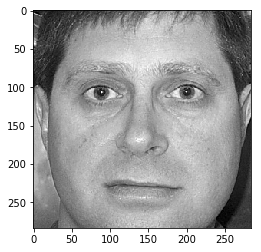

In [14]:
# 测试上面函数是否正常
face_cascade=cv2.CascadeClassifier('E:\PyProjects\DataSet\FireAI\cascade_files/haarcascade_frontalface_alt.xml')
face_imgs, encode_labels, label_encoder,labels=load_train_set('E:\PyProjects\/DataSet\FireAI\/faces_dataset/train',face_cascade)
print(len(face_imgs)) # 有53张脸，但是检测得到56个结果，显然有几张图片中检测了多张脸
# 显示任一张人脸
# 由于cv2读取的是BGR，而plt是RGB，故而需要转化一下
plt.imshow(face_imgs[3],cmap='gray')

In [15]:
def find_false_faces(face_imgs):
    '''
    将所有脸部照片显示出来,如果发现有错误的，按d键，记录下错误的脸部照片
    '''
    need_del_ids=[]
    for idx,face in enumerate(face_imgs):
        cv2.namedWindow('check', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('check', 500, 500)
        cv2.imshow('check', face)
        key = cv2.waitKey(0)

        if key==27: # 如果输入时Esc，则退出循环
            print('esc to exit')
            break
        elif key==100: # 如果输入d键，则记录该脸对应的id
            need_del_ids.append(idx)
    cv2.destroyAllWindows()
    print('finished...')
    return need_del_ids

In [16]:
faces=face_imgs.copy()
# need_del_ids=find_false_faces(faces)
need_del_ids=[11,41,46] # 避免再次选择

finished...


In [17]:
print(need_del_ids)

[11, 41, 46]


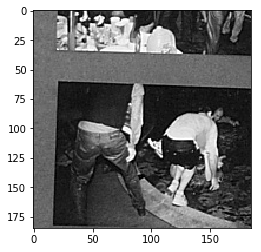

In [18]:
# 可以看出，图片中标号为11,41,46的图片并不是人脸，而是错误
# 查看这些错误图片
plt.imshow(face_imgs[11],cmap='gray')

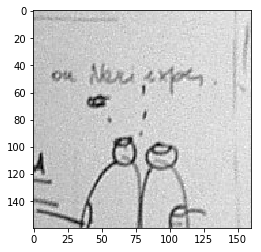

In [19]:
plt.imshow(face_imgs[41],cmap='gray')

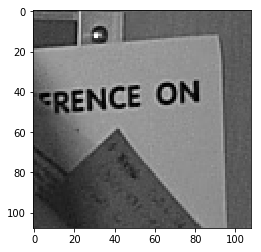

In [20]:
plt.imshow(face_imgs[46],cmap='gray')

In [21]:
# 从数据集中删除这三张照片对应的信息
face_imgs=np.delete(np.array(face_imgs), need_del_ids, axis=0)
encode_labels=np.delete(np.array(encode_labels), need_del_ids, axis=0)
labels=np.delete(np.array(labels), need_del_ids,axis=0)
print(face_imgs.shape) # 53张图没错，元素已经变成了np.ndarray,故而只有行

(53,)


In [23]:
# 构建createLBPHFaceRecognizer分类模型
from cv2.face import LBPHFaceRecognizer_create
recognizer=LBPHFaceRecognizer_create()
recognizer.train(face_imgs, encode_labels) # 模型训练

In [28]:
# 用训练好的模型预测新照片
def predict_imgs(new_imgs_folder, face_cascade,recognizer,label_encoder):
    '''
    用训练好的人脸识别器来识别人脸'''
    img_paths=glob(new_imgs_folder+'/*.*')
    predicted_imgs=[]
    for img_path in img_paths:
        image=cv2.imread(img_path)
        gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        faces=face_cascade.detectMultiScale(gray,1.1, 2, minSize=(100,100))
        for (x, y, w, h) in faces:
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),3)
            predicted_index, conf = recognizer.predict(gray[y:y+h, x:x+w])
            predicted_label=label_encoder.inverse_transform([predicted_index])[0]
            cv2.putText(image, predicted_label,(x,y-20), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 3)
        predicted_imgs.append(image)
    return predicted_imgs

e:\programsoft\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
e:\programsoft\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
e:\programsoft\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
e:\programsoft\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

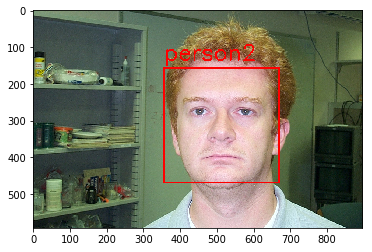

In [34]:
predicted=predict_imgs('E:\PyProjects\/DataSet\/FireAI\/faces_dataset\/test',face_cascade,recognizer,label_encoder)
# 随便显示几张预测后的图片
img1=predicted[3].copy()
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
plt.imshow(img1)

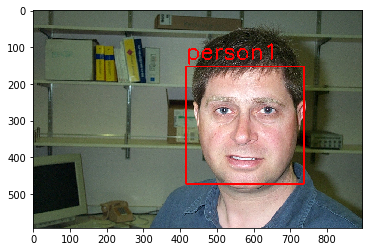

In [35]:
img1=predicted[0].copy()
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
plt.imshow(img1)

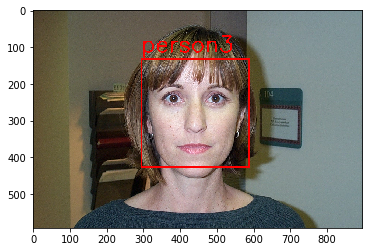

In [36]:
img1=predicted[6].copy()
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
plt.imshow(img1)

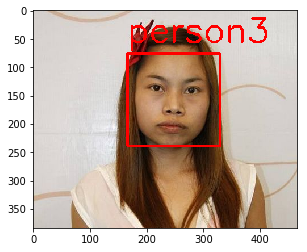

In [37]:
img1=predicted[9].copy()
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
plt.imshow(img1)